In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from keras_tuner import HyperModel
from tensorflow.keras import layers, models
from keras_tuner.tuners import RandomSearch

2025-05-30 10:08:01.301645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_and_clean_csv(path):
    df = pd.read_csv(path)
    
    # Drop last 6 rows
    df = df.iloc[:-6]
    
    # Convert date column to datetime
    df['#date+time'] = pd.to_datetime(df['#date+time'], errors='coerce')
    df = df.rename(columns={'#date+time': 'date_time'})
    
    # Convert all other columns to numeric
    for col in df.columns:
        if col != 'date_time':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df
def wind_to_uv(speed, direction_deg):
    # Convert to radians
    direction_rad = np.deg2rad(direction_deg)

    # U = -speed * sin(direction), V = -speed * cos(direction)
    # This converts FROM meteorological TO Cartesian
    u = -speed * np.sin(direction_rad)
    v = -speed * np.cos(direction_rad)
    return u, v

def prepare_dataframe(df):
    # Rename columns to a consistent format
    df = df.rename(columns={
        df.columns[0]: 'date_time',
        df.columns[1]: 'pwl',
        df.columns[2]: 'wsd',
        df.columns[3]: 'wdr'
    })
    
    # Convert wind to U/V components
    u, v = wind_to_uv(df['wsd'], df['wdr'])
    df[['u', 'v']] = np.column_stack((u, v))
    
    # Drop raw wind columns
    df.drop(columns=['wsd', 'wdr'], inplace=True)
    
    return df

def input_output_arrays(pl_df, po_df, wl_window, wind_window):

    wl_window = wl_window * 10
    wind_window = wind_window * 10

    pl_df = pl_df.reset_index(drop=True)
    po_df = po_df.reset_index(drop=True)

    pl_pwl = pl_df['pwl'].to_numpy()
    pl_u   = pl_df['u'].to_numpy()
    pl_v   = pl_df['v'].to_numpy()
    po_pwl = po_df['pwl'].to_numpy()

    X, y, indices = [], [], []

    for t in range(max(wl_window, wind_window), len(pl_df) - wl_window):
        # Water level window: centered at t
        wl_slice = slice(t - wl_window, t + wl_window + 1)

        # Wind window: past `wind_window` values ending at t
        wind_slice = slice(t - wind_window + 1, t + 1)

        pwl_input = pl_pwl[wl_slice]
        u_input = pl_u[wind_slice]
        v_input = pl_v[wind_slice]
        target = po_pwl[t]

        if (
            np.isnan(pwl_input).any() or
            np.isnan(u_input).any() or
            np.isnan(v_input).any() or
            np.isnan(target)
        ):
            continue

        features = np.concatenate([pwl_input, u_input, v_input])
        X.append(features)
        y.append(target)
        indices.append(t)

    return np.array(X), np.array(y), np.array(indices)

file_paths = {
    'po11': '/home/ryan/Downloads/po_2011-2012.csv',
    'pl11': '/home/ryan/Downloads/pl_2011-2012.csv',
    'po13': '/home/ryan/Downloads/po_2013-2014.csv',
    'pl13': '/home/ryan/Downloads/pl_2013-2014.csv',
    'po15': '/home/ryan/Downloads/po_2015-2016.csv',
    'pl15': '/home/ryan/Downloads/pl_2015-2016.csv',
}

def calculate_central_frequency_percentage(testing_label_array, predictions, cm):
  """Find the percentage of predictions with a central frequency (CF) of less than
  or equal to a given number of centimeters (cm)

	Args:
        testing_label_array (array): Testing labels

        predictions (array): Model predictions

        cm (int): Number of centimeters

	Returns:
		(float): central frequency (CF) percentage
	"""
  less_than_cm_counter = 0

  # Convert cm to m
  cm_to_m = cm / 100

  for index, prediction in enumerate(predictions):
    if abs(testing_label_array[index] - prediction) <= cm_to_m:
      less_than_cm_counter += 1

  cf_percentage = (less_than_cm_counter / len(predictions)) * 100

  return cf_percentage


def evaluate_model(model, testing_input_array, testing_label_array):
  """Calculates loss, makes predictions, and calculates Central Frequency (CF),
  Mean Squared Error (MSE), Root Mean Squared Error(RMSE), Mean Absolute Error (MAE),
  Median Absolute Error, and R-squared (R2)

	Args:
        model (tf.keras.model): The trained model

        testing_input_array (array): Testing inputs

        testing_label_array (array): Testing labels
	"""
  print("Calculating Loss:")
  test_loss = model.evaluate(testing_input_array, testing_label_array, batch_size = len(testing_input_array))

  print("Loss:", test_loss)


  print("\nGenerating output predictions with model:")
  predictions = model.predict(testing_input_array, batch_size = len(testing_input_array))

  # Calculate evaluation metrics
  cf_15cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 15)
  cf_5cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 5)
  cf_1cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 1)
  mse = mean_squared_error(testing_label_array, predictions)
  rmse = root_mean_squared_error(testing_label_array, predictions)
  mae = mean_absolute_error(testing_label_array, predictions)
  medae = median_absolute_error(testing_label_array, predictions)
  r2 = r2_score(testing_label_array, predictions)

  print("\nCentral Frequency Percentage 15cm:", cf_15cm_percentage)
  print("\nCentral Frequency Percentage 5cm:", cf_5cm_percentage)
  print("\nCentral Frequency Percentage 1cm:", cf_1cm_percentage)
  print("Mean Squared Error:", mse)
  print("Root Mean Squared Error:", rmse)
  print("Mean Absolute Error:", mae)
  print("Median Absolute Error:", medae)
  print("R-squared:", r2)

datasets = {key: load_and_clean_csv(path) for key, path in file_paths.items()}

for name, df in datasets.items():
    datasets[name] = prepare_dataframe(df)


/tmp/ipykernel_877736/2923689263.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_877736/2923689263.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [3]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=3, wind_window=3)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=3, wind_window=3)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=3, wind_window=3)


In [7]:

class WaterLevelHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Input(shape=(self.input_dim,)))

        # Tune number of hidden units in the first Dense layer
        model.add(layers.Dense(units=hp.Int('units1', min_value=10, max_value=200, step=10),
                               activation='relu'))

        # Optional second dense layer
        if hp.Boolean('use_second_layer'):
            model.add(layers.Dense(units=hp.Int('units2', min_value=10, max_value=100, step=10),
                                   activation='relu'))

        # Tune dropout rate
        model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.005)))

        model.add(layers.Dense(1, kernel_initializer='normal'))

        # Tune learning rate
        lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='mse',
                      metrics=['mae'])
        return model

input_dim = X_train.shape[1]

hypermodel = WaterLevelHyperModel(input_dim)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory='kt_dir',
    project_name='wind_waterlevel_model'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

tuner.search(X_train, y_train,
             validation_data=(X_valid, y_valid),
             epochs=50,
             batch_size=len(X_train),
             callbacks=[early_stopping],
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]


Trial 40 Complete [00h 00m 16s]
val_loss: 0.15436787903308868

Best val_loss So Far: 0.13650496304035187
Total elapsed time: 00h 10m 09s

Search: Running Trial #41

Value             |Best Value So Far |Hyperparameter
190               |190               |units1
True              |True              |use_second_layer
0.4               |0.13              |dropout_rate
0.0015186         |0.0059431         |lr
50                |70                |units2

Epoch 1/50


KeyboardInterrupt: 

In [ ]:


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=1000,
    batch_size=len(X_train),
    validation_batch_size=len(X_valid),
    callbacks=[early_stopping],
    verbose=1
)
best_model.summary()
# Evaluate on validation or test set
evaluate_model(best_model, X_valid, y_valid)


Epoch 1/1000


/home/ryan/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5380 - mae: 0.5880 - val_loss: 4.9158 - val_mae: 2.0319
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 5.7923 - mae: 2.2389 - val_loss: 1.0053 - val_mae: 0.8932
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1.3792 - mae: 1.0351 - val_loss: 2.2841 - val_mae: 1.2827
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 3.5024 - mae: 1.5229 - val_loss: 0.8686 - val_mae: 0.7783
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 1.5019 - mae: 0.9849 - val_loss: 0.5336 - val_mae: 0.6252
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.7912 - mae: 0.7353 - val_loss: 1.0346 - val_mae: 0.9690
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1.3223 - mae: 1.0310 - val_loss: 1.2523 - val_mae: 1.0376
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.5918 - mae: 1.1364 - val_loss: 1.2388 - val_mae: 1.0130
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 1.5391 - mae

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │        14,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,625 (451.66 KB)

 Trainable params: 38,541 (150.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 77,084 (301.11 KB)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0150 - mae: 0.0974
Loss: [0.015035164542496204, 0.09741291403770447]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step

Central Frequency Percentage 15cm: 79.40305502886726

Central Frequency Percentage 5cm: 30.648288203839023

Central Frequency Percentage 1cm: 6.188883444470483
Mean Squared Error: 0.01503516456865372
Root Mean Squared Error: 0.12261796185165418
Mean Absolute Error: 0.09741291278605137
Median Absolute Error: 0.08441050720214838
R-squared: 0.34442843164289494


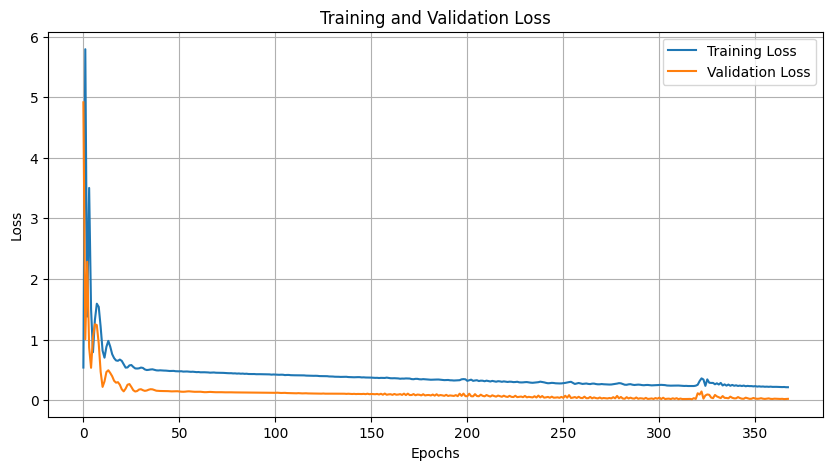

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


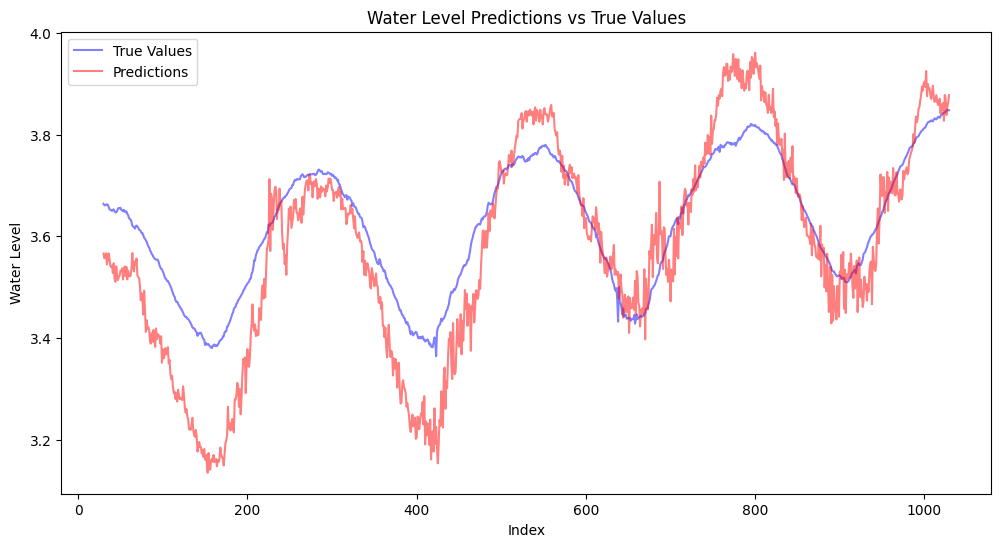

In [ ]:
#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

timestamps = datasets['po15'].iloc[indices_test]['date_time']

# Get predictions from best model
predictions = best_model.predict(X_test, batch_size=len(X_test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(timestamps[:1000], y_test[:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(timestamps[:1000], predictions[:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.title('Neural Net Predicted vs Measured Water Level')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Best hyperparameters:
units1: 200
use_second_layer: True
dropout_rate: 0.485
lr: 0.005493060411680128
units2: 70


Neural net predicted waterlevel vs measured waterlevel
Water level (m / station datum)
Time Stamps
Date